# A model for predicting incremental diameter growth

Here we will adapt the basic diameter growth model for large trees from the Forest Vegetation Simulator into a aggregates monthly predictions of diameter growth over arbitrary periods of one or more months. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

import jax
from jax import numpy as jnp
from jax import random, jit
from jax.lax import scan
from functools import partial

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

import pandas as pd
import geopandas as gpd
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from tqdm.notebook import tqdm
# import warnings

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(20)

In [3]:
# def scan(f, init, xs, length=None):
#     if xs is None:
#       xs = [None] * length
#     carry = init
#     ys = []
#     for x in xs:
#       carry, y = f(carry, x)
#       ys.append(y)
#     return carry, np.stack(ys)

In [4]:
def grow_step(dbh, covars, coefs):
    b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, bark_b1, bark_b2 = coefs
    location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars
    size = b1 * jnp.log(dbh) + b2 * (dbh**2)
    site = b3 * jnp.log(site_index) + \
           b4 * (slope * jnp.cos(asp)) + b5 * (slope * jnp.sin(asp)) + \
           b6 * slope + b7 * slope**2 + \
           b8 * elev + b9 * elev ** 2
    comp = b10 * crown_ratio + b11 * crown_ratio**2 + \
           b12 * comp_tree + b13 * comp_stand
    ln_dds = b0 + size + site + comp
    
    dds = jnp.exp(ln_dds)
    
    dib_start = bark_b1*(dbh**bark_b2)
    dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
    dib_end = dib_start + dg_ib
    dbh_end = (dib_end / bark_b1)**(1/bark_b2)
    dg_ob = dbh_end - dbh
    
    return dbh_end, dg_ob

def grow(dbh, covars, coefs):
    partial_grow = partial(grow_step, coefs=coefs)
    end_dbh, dgs = scan(partial_grow, init=dbh, xs=covars)
    return end_dbh, dgs    

In [5]:
def grow(dbh, location, site_index, asp, slope, elev, cr_start, cr_end, 
         comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end, 
         num_steps, 
         obs_dg=None):
    
    dbh = jnp.atleast_1d(dbh)
    num_trees = dbh.size
    location = jnp.atleast_1d(location)
    site_index = jnp.atleast_1d(site_index)
    asp = jnp.atleast_1d(asp)
    slope = jnp.atleast_1d(slope)
    elev = jnp.atleast_1d(elev)

    b0 = 0
    b1 = 0.802905 # ln(dbh)
    b2 = -0.0000896 # dbh**2
    b3 = 0.495162 # ln(site_index)
    b4 = 0.014165 # slope*cos(asp)
    b5 = 0.003263 # slope*sin(asp)
    b6 = 0.340401 # slope
    b7 = 0  # slope**2
    b8 = -0.009845 # elev
    b9 = 0 # elev**2
    b10 = 1.9369120  # crown_ratio
    b11 = 0 # crown_ratio**2
    b12 = -0.001827  # comp_tree  # BAL / ln(dbh+1)
    b13 = -0.12947  # comp_stand  # ln(BA)
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    location = jnp.full((num_steps, num_trees), location)
    site_index = jnp.full((num_steps, num_trees), site_index)
    asp = jnp.full((num_steps, num_trees), site_index) 
    slope = jnp.full((num_steps, num_trees), slope)
    elev = jnp.full((num_steps, num_trees), elev)
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    covars = location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand

    def step(dbh, covars):
        location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars

        size = b1 * jnp.log(dbh) + b2 * (dbh**2)
        site = b3 * jnp.log(site_index) + \
              b4 * (slope * jnp.cos(asp)) + b5 * (slope * jnp.sin(asp)) + \
              b6 * slope + b7 * slope**2 + \
              b8 * elev + b9 * elev ** 2
        comp = b10 * crown_ratio + b11 * crown_ratio**2 + \
              b12 * comp_tree + b13 * comp_stand
        ln_dds = b0 + size + site + comp

        dds = jnp.exp(ln_dds)

        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh

        return dbh_end, dg_ob
    
    # scan returns arrays of final dbh (shape: (n_trees,)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    end_dbhs, growth = scan(step, dbh, covars, length=num_steps)       
    return growth

In [6]:
DBH = 10.
LOCATION = 0
SITE_INDEX = 105
ASP = 0
SLOPE = 0
ELEV = 10
CR_START = 1.0
CR_END = 0.2
COMP_TREE_START = 5
COMP_TREE_END = 5
COMP_STAND_START = 5
COMP_STAND_END = 5
NUM_STEPS = 20

result = grow(DBH, LOCATION, SITE_INDEX, ASP, SLOPE, ELEV, 
              CR_START, CR_END, COMP_TREE_START, COMP_TREE_END, COMP_STAND_START, COMP_STAND_END,
              num_steps=NUM_STEPS)

result.shape, result

((20, 1),
 DeviceArray([[9.225378 ],
              [8.7691345],
              [7.83996  ],
              [6.8757286],
              [5.992317 ],
              [5.2175827],
              [4.550434 ],
              [3.9800262],
              [3.493103 ],
              [3.0768433],
              [2.7199097],
              [2.4126282],
              [2.1469803],
              [1.9163132],
              [1.715126 ],
              [1.5389786],
              [1.3841019],
              [1.2474365],
              [1.1264343],
              [1.0189514]], dtype=float32))

In [7]:
DBH = jnp.array([0.1, 10.0])
LOCATION = jnp.array([0, 1])
SITE_INDEX = jnp.array([105, 105])
ASP = jnp.array([0, 0])
SLOPE = jnp.array([0, 0])
ELEV = jnp.array([10, 10])
CR_START = jnp.array([1.0, 1.0])
CR_END = jnp.array([0.2, 0.2])
COMP_TREE_START = jnp.array([5, 5])
COMP_TREE_END = jnp.array([5, 5])
COMP_STAND_START = jnp.array([5, 5])
COMP_STAND_END = jnp.array([5, 5])
NUM_STEPS = 20

result = grow(DBH, LOCATION, SITE_INDEX, ASP, SLOPE, ELEV, 
              CR_START, CR_END, COMP_TREE_START, COMP_TREE_END, COMP_STAND_START, COMP_STAND_END,
              num_steps=NUM_STEPS)

result.shape, result

((20, 2),
 DeviceArray([[2.4369514, 9.225378 ],
              [6.856844 , 8.7691345],
              [8.096249 , 7.83996  ],
              [7.6712112, 6.8757286],
              [6.896076 , 5.992317 ],
              [6.099304 , 5.2175827],
              [5.3657875, 4.550434 ],
              [4.7159004, 3.9800262],
              [4.1493073, 3.493103 ],
              [3.658619 , 3.0768433],
              [3.2344627, 2.7199097],
              [2.8675804, 2.4126282],
              [2.5495758, 2.1469803],
              [2.273117 , 1.9163132],
              [2.0319977, 1.7151413],
              [1.8209534, 1.5389786],
              [1.635582 , 1.3841019],
              [1.4722366, 1.2474365],
              [1.3277893, 1.1264267],
              [1.1996994, 1.0189438]], dtype=float32))

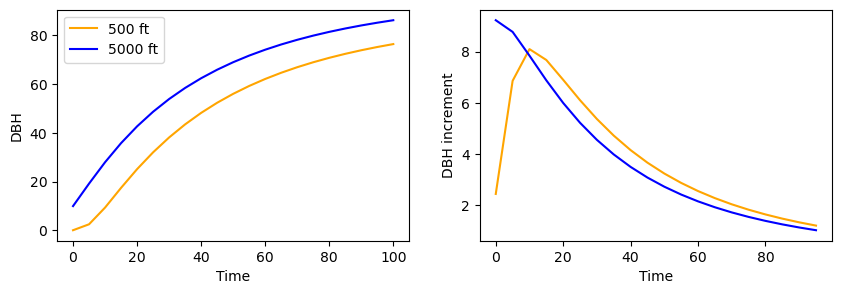

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

results = np.insert(np.cumsum(result.T, axis=1).T + DBH, 0, DBH, axis=0).T
years = np.arange(0, (NUM_STEPS+1)*5, 5)
ax[0].plot(years, results[0], color='orange', label='500 ft')
ax[0].plot(years, results[1], color='blue', label='5000 ft')
ax[0].set(xlabel='Time', ylabel='DBH')
ax[0].legend()
ax[1].plot(years[:-1], np.diff(results[0]), color='orange')
ax[1].plot(years[:-1], np.diff(results[1]), color='blue')
ax[1].set(xlabel='Time', ylabel='DBH increment')
plt.show()

In [9]:
CSV = '../data/interim/FIA_remeasured_trees_for_training.csv'
df = pd.read_csv(CSV)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   STATECD            290429 non-null  int64  
 1   UNITCD             290429 non-null  int64  
 2   COUNTYCD           290429 non-null  int64  
 3   PLOT               290429 non-null  int64  
 4   PLOT_ID            290429 non-null  int64  
 5   SUBPLOT            290429 non-null  int64  
 6   SUBPLOT_ID         290429 non-null  int64  
 7   PLOT_CN            290429 non-null  int64  
 8   PLOT_CN_NEXT       290429 non-null  int64  
 9   TREE_CN            220620 non-null  float64
 10  TREE_CN_NEXT       269952 non-null  float64
 11  TREE_ID            290429 non-null  int64  
 12  LAT                290429 non-null  float64
 13  LON                290429 non-null  float64
 14  ELEV               290429 non-null  float64
 15  VARIANT            290429 non-null  object 
 16  LO

In [10]:
gdf = gpd.read_file('../data/raw/FVS_Variants_and_Locations.shp')
variants = np.unique(df.VARIANT)
locations = np.sort(np.array([*set(np.unique(gdf.loc[gdf.FVSVariant.isin(variants), 'FVSLocCode'])).union(np.unique(df.LOCATION))], dtype='int'))
plots = np.unique(df.PLOT_ID)
variants, locations, plots

(array(['BM', 'CA', 'CR', 'EC', 'IE', 'NC', 'PN', 'SO', 'WC', 'WS'],
       dtype=object),
 array([103, 105, 106, 110, 113, 114, 116, 117, 118, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 224,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 417,
        501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
        514, 515, 516, 517, 518, 601, 602, 603, 604, 605, 606, 607, 608,
        609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621,
        699, 702, 703, 705, 708, 709, 710, 711, 712, 800]),
 array([ 60101550679,  60101551744,  60101551969, ..., 530907170686,
        530907182459, 530907572668]))

In [11]:
variant_encoder = LabelEncoder().fit(variants)
location_encoder = LabelEncoder().fit(locations)

df['VAR_IDX'] = variant_encoder.transform(df['VARIANT'])
df['LOC_IDX'] = location_encoder.transform(df['LOCATION'])

In [12]:
df.columns

Index(['STATECD', 'UNITCD', 'COUNTYCD', 'PLOT', 'PLOT_ID', 'SUBPLOT',
       'SUBPLOT_ID', 'PLOT_CN', 'PLOT_CN_NEXT', 'TREE_CN', 'TREE_CN_NEXT',
       'TREE_ID', 'LAT', 'LON', 'ELEV', 'VARIANT', 'LOCATION', 'SLOPE',
       'ASPECT', 'TOPO_POSITION_PNW', 'MEASYEAR', 'MEASMON', 'MEASDAY',
       'MEASYEAR_NEXT', 'MEASMON_NEXT', 'MEASDAY_NEXT', 'SICOND', 'SIBASE',
       'SISP', 'SITECLCD', 'AZIMUTH', 'DISTANCE', 'STATUSCD', 'STATUSCD_NEXT',
       'MORTYR', 'MORTYR_NEXT', 'TPA_UNADJ', 'FIA_SPCD', 'FVS_ALPHA',
       'FVS_SPP', 'FVS_SPP_IDX', 'COMMON_NAME', 'DBH', 'DBH_NEXT', 'HT',
       'HT_NEXT', 'ACTUALHT', 'ACTUALHT_NEXT', 'CR', 'CR_NEXT', 'CCLCD',
       'ESTHT', 'ESTHT_NEXT', 'PTCCF', 'PTCCF_NEXT', 'PTBAPA', 'PTBAPA_NEXT',
       'DOMHT', 'RELHT', 'DOMHT_NEXT', 'RELHT_NEXT', 'BAPALARGER',
       'BAPALARGER_NEXT', 'VAR_IDX', 'LOC_IDX'],
      dtype='object')

In [13]:
RAW_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_ID', 'SICOND', 'ASPECT', 'SLOPE', 'ELEV',
              'DBH', 'CR', 'CR_NEXT', 'BAPALARGER', 'BAPALARGER_NEXT', 
              'PTBAPA', 'PTBAPA_NEXT']
RAW_OBS = ['DBH_NEXT']

MODEL_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_ID', 'SICOND', 'ASP', 'SLOPE', 'ELEV', 
               'DBH', 'CR_START', 'CR_END', 'COMP_TREE_START', 'COMP_TREE_END', 
               'COMP_STAND_START', 'COMP_STAND_END']
MODEL_OBS = ['DG_OBS']

data = df.loc[(df.FIA_SPCD == 202)&(df.STATUSCD==1)&(df.STATUSCD_NEXT==1)&((df.MEASYEAR_NEXT - df.MEASYEAR) == 10)].dropna(subset=RAW_COVARS).sample(1000)[RAW_COVARS + RAW_OBS].copy()
data[['CR_START', 'CR_END']] = data[['CR', 'CR_NEXT']] / 100.
data['COMP_TREE_START'] = data['BAPALARGER'] / np.log(data['DBH'] + 1.0)
data['COMP_TREE_END'] = data['BAPALARGER_NEXT'] / np.log(data['DBH_NEXT'] + 1.0)
data['COMP_STAND_START'] = np.log(data['PTBAPA'])
data['COMP_STAND_END'] = np.log(data['PTBAPA_NEXT'])
data['ASP'] = np.deg2rad(data['ASPECT'])
data['SLOPE'] = data['SLOPE'] / 100.
data['ELEV'] = data['ELEV'] / 100.
data['DG_OBS'] = data['DBH_NEXT'] - data['DBH']

to_model = data[MODEL_COVARS + MODEL_OBS]
to_model.describe()

,VAR_IDX,LOC_IDX,PLOT_ID,SICOND,ASP,SLOPE,ELEV,DBH,CR_START,CR_END,COMP_TREE_START,COMP_TREE_END,COMP_STAND_START,COMP_STAND_END,DG_OBS
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.307000,67.265000,4.160207e+11,106.647000,3.214198,0.390020,28.314000,18.658500,0.514410,0.453800,9.395969,11.067273,3.684626,3.989704,1.578900
std,2.790078,11.084026,1.297100e+11,40.266758,1.841592,0.242133,14.541556,14.048454,0.206462,0.189205,10.549262,11.461179,0.791211,0.605500,1.330968
min,0.000000,4.000000,6.010155e+10,22.000000,0.000000,0.000000,1.000000,1.000000,0.050000,0.050000,0.000000,0.000000,-0.529738,1.106883,-3.000000
25%,3.000000,62.000000,4.101040e+11,70.000000,1.740966,0.200000,17.000000,7.800000,0.350000,0.300000,1.883858,2.438169,3.253106,3.674540,0.700000
50%,6.000000,68.000000,4.102020e+11,106.000000,3.316126,0.350000,29.000000,12.600000,0.500000,0.400000,6.415747,7.869849,3.783142,4.031455,1.300000
75%,8.000000,74.000000,5.306046e+11,139.000000,4.712389,0.600000,39.000000,28.675000,0.650000,0.600000,13.575679,17.002967,4.222996,4.390608,2.200000
max,9.000000,87.000000,5.309072e+11,207.000000,6.283185,1.150000,77.000000,75.500000,0.990000,0.990000,116.529460,97.477588,5.384092,5.420095,13.100000


In [14]:
PRIOR_MEAN = dict(  # 10 step priors
    b0 = -0.739354,    # intercept
    b1 = 0.80,    # ln(dbh)
    b2 = -0.0000896,  # dbh**2
    b3 = 0.49,    # ln(site_index)
    b4 = 0.014165,    # slope*cos(asp)
    b5 = 0.003263,       # slope*sin(asp)
    b6 = -0.340401,    # slope
    b7 = 0,        # slope**2
    b8 = -0.009845,       # elev 
    b9 = 0,       # elev**2
    b10 = 1.936912,   # crown_ratio
    b11 = 0.,     # crown_ratio**2
    b12 = -0.001827,  # comp_tree (BAL/ln(dbh+1))
    b13 = -0.129474,   # comp_stand (lnBA)
)

PRIOR_STD = {
    'b0': 0.5,
    'b1': 0.5,
    'b2': 0.01,
    'b3': 0.3,
    'b4': 0.01,
    'b5': 0.02,
    'b6': 0.1,
    'b7': 0.001,
    'b8': 0.01,
    'b9': 0.0001,
    'b10': 0.5,
    'b11': 0.01,
    'b12': 0.1,
    'b13': 0.1,
}

In [15]:
len(locations), len(variants)

(88, 10)

In [16]:
# diameter growth model
# original fvs (5-yr) vs refit on FIA (5-yr)
# annualize and hierarchy (for refit on FIA too?) for refitting
# switch to potential * modifier
# add climatic modifiers and compare with annualized climate-proxy version
# map climatic modifiers for several species at a snapshot in the future

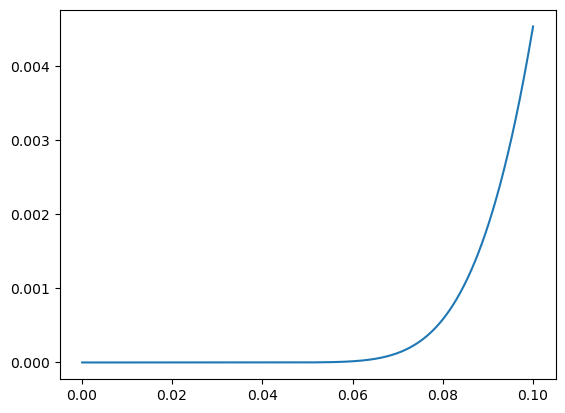

In [17]:
xs = np.linspace(0,0.1, 1000)
plt.plot(xs, np.exp(dist.InverseGamma(1.0, 1.0).log_prob(xs)));

(0.8, 0.5)

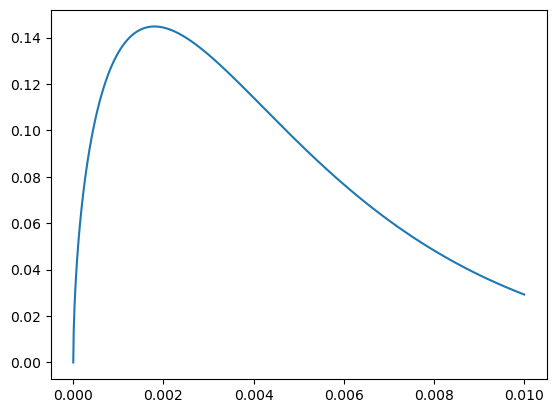

In [18]:
xs = np.linspace(0,10,1000)
mu, sd = 5, 4
param = dist.Gamma(concentration=(mu/sd)**2, rate=mu/(sd**2))
plt.plot(xs*1e-3, np.exp((param).log_prob(xs)))
PRIOR_MEAN['b1'], PRIOR_STD['b1']

In [19]:
pd.factorize(df.PLOT_ID.values)

(array([    0,     0,     0, ..., 12155, 12155, 12155]),
 array([530907572668, 530907182459, 530907170686, ...,  60101551969,
         60101551744,  60101550679]))

In [20]:
def dg_norm(X, num_steps, y=None, num_locations=88, num_variants=10):
    (variant, location, plot, site_index, asp, slope, elev, dbh, cr_start, cr_end, 
     comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end) = X
    
    dbh = jnp.asarray(dbh).reshape(-1,)
    num_trees = dbh.size
    location = jnp.asarray(location).reshape(-1,)
    
    plot, plot_id = pd.factorize(plot)
    num_plots = plot[-1] + 1
    
    plot = jnp.asarray(plot).reshape(-1,)
    site_index = jnp.asarray(site_index).reshape(-1,)
    asp = jnp.asarray(asp).reshape(-1,)
    slope = jnp.asarray(slope).reshape(-1,)
    elev = jnp.asarray(elev).reshape(-1,)
    
    norm = jnp.array([
        jnp.log(dbh),
        dbh**2,
        jnp.log(site_index),
        slope*jnp.cos(asp),
        slope*jnp.sin(asp),
        slope,
        slope**2,
        elev,
        elev**2,
        cr_start,
        cr_start**2,
        comp_tree_start,
        comp_stand_start
    ])
    norm_mu = norm.mean(axis=1)
    norm_sd = norm.std(axis=1)
    
    b0z_mu = numpyro.sample('b0z_mu', dist.Normal(0., 10.))
    b0z_sd = numpyro.sample('b0z_sd', dist.InverseGamma(0.1, 0.1))
    b1z_mu = numpyro.sample('b1z_mu', dist.Normal(0., 10.))
    b1z_sd = numpyro.sample('b1z_sd', dist.InverseGamma(0.1, 0.1))
    b2z_mu = numpyro.sample('b2z_mu', dist.Normal(0., 10.))
    b2z_sd = numpyro.sample('b2z_sd', dist.InverseGamma(0.1, 0.1))
    b3z_mu = numpyro.sample('b3z_mu', dist.Normal(0., 10.))
    b3z_sd = numpyro.sample('b3z_sd', dist.InverseGamma(0.1, 0.1))
    b4z_mu = numpyro.sample('b4z_mu', dist.Normal(0., 10.))
    b4z_sd = numpyro.sample('b4z_sd', dist.InverseGamma(0.1, 0.1))
    b5z_mu = numpyro.sample('b5z_mu', dist.Normal(0., 10.))
    b5z_sd = numpyro.sample('b5z_sd', dist.InverseGamma(0.1, 0.1))
    b6z_mu = numpyro.sample('b6z_mu', dist.Normal(0., 10.))
    b6z_sd = numpyro.sample('b6z_sd', dist.InverseGamma(0.1, 0.1))
    b7z_mu = numpyro.sample('b7z_mu', dist.Normal(0., 10.))
    b7z_sd = numpyro.sample('b7z_sd', dist.InverseGamma(0.1, 0.1))
    b8z_mu = numpyro.sample('b8z_mu', dist.Normal(0., 10.))
    b8z_sd = numpyro.sample('b8z_sd', dist.InverseGamma(0.1, 0.1))
    b9z_mu = numpyro.sample('b9z_mu', dist.Normal(0., 10.))
    b9z_sd = numpyro.sample('b9z_sd', dist.InverseGamma(0.1, 0.1))
    b10z_mu = numpyro.sample('b10z_mu', dist.Normal(0., 10.))
    b10z_sd = numpyro.sample('b10z_sd', dist.InverseGamma(0.1, 0.1))
    b11z_mu = numpyro.sample('b11z_mu', dist.Normal(0., 10.))
    b11z_sd = numpyro.sample('b11z_sd', dist.InverseGamma(0.1, 0.1))
    b12z_mu = numpyro.sample('b12z_mu', dist.Normal(0., 10.))
    b12z_sd = numpyro.sample('b12z_sd', dist.InverseGamma(0.1, 0.1))
    b13z_mu = numpyro.sample('b13z_mu', dist.Normal(0., 10.))
    b13z_sd = numpyro.sample('b13z_sd', dist.InverseGamma(0.1, 0.1))
    
    with numpyro.plate('variants', num_variants):
        b0z = numpyro.sample('b0z', dist.Normal(b0z_mu, b0z_sd))
        b1z = numpyro.sample('b1z', dist.Normal(b1z_mu, b1z_sd))  # ln(dbh)
        b2z = numpyro.sample('b2z', dist.Normal(b2z_mu, b2z_sd))  # dbh**2
        b3z = numpyro.sample('b3z', dist.Normal(b3z_mu, b3z_sd))  # ln(site_index)
        b4z = numpyro.sample('b4z', dist.Normal(b4z_mu, b4z_sd))  # slope*cos(asp)
        b5z = numpyro.sample('b5z', dist.Normal(b5z_mu, b5z_sd))  # slope*sin(asp)
        b6z = numpyro.sample('b6z', dist.Normal(b6z_mu, b6z_sd))  # slope
        b7z = numpyro.sample('b7z', dist.Normal(b7z_mu, b7z_sd))  # slope**2
        b8z = numpyro.sample('b8z', dist.Normal(b8z_mu, b8z_sd))  # elev
        b9z = numpyro.sample('b9z', dist.Normal(b9z_mu, b9z_sd))  # elev**2
        b10z = numpyro.sample('b10z', dist.Normal(b10z_mu, b10z_sd))  # crown_ratio
        b11z = numpyro.sample('b11z', dist.Normal(b11z_mu, b11z_sd))  # crown_ratio**2
        b12z = numpyro.sample('b12z', dist.Normal(b12z_mu, b12z_sd))  # comp_tree  # BAL / ln(dbh+1)
        b13z = numpyro.sample('b13z', dist.Normal(b13z_mu, b13z_sd))  # comp_stand  # ln(BA)
    
    with numpyro.plate('locations', num_locations):
        e_loc = numpyro.sample('e_loc', dist.Normal(0, 1.0)) # random effect of location
    
    if y is not None:
        with numpyro.plate('plots', num_plots):
            e_plot = numpyro.sample('e_plot', dist.Normal(0, 1.0)) # random effect of plot
    else:
        e_plot = 0 * plot
        
    # b1z = numpyro.sample('b1z', dist.Normal(0., 1.0))  # ln(dbh)
    # b2z = numpyro.sample('b2z', dist.Normal(0., 1.0))  # dbh**2
    # b3z = numpyro.sample('b3z', dist.Normal(0., 1.0))  # ln(site_index)
    # b4z = numpyro.sample('b4z', dist.Normal(0., 1.0))  # slope*cos(asp)
    # b5z = numpyro.sample('b5z', dist.Normal(0., 1.0))  # slope*sin(asp)
    # b4z = 0
    # b5z = 0
    # b6z = numpyro.sample('b6z', dist.Normal(0., 1.0))  # slope
    # b6z = 0
    # b7z = numpyro.sample('b7z', dist.Normal(0, 1.0))  # slope**2
    # b7z = 0
    # b8z = numpyro.sample('b8z', dist.Normal(0., 1.0))  # elev
    # b8z = 0
    # b9z = numpyro.sample('b9z', dist.Normal(0., 1.0)) # elev**2
    # b9z = 0
    # b10z = numpyro.sample('b10z', dist.Normal(0., 1.0))  # crown_ratio
    # b11z = numpyro.sample('b11z', dist.Normal(0., 1.0))  # crown_ratio**2
    # b11z = 0
    # b12z = numpyro.sample('b12z', dist.Normal(0., 1.0))  # comp_tree  # BAL / ln(dbh+1)
    # b13z = numpyro.sample('b13z', dist.Normal(0., 1.0)) # comp_stand  # ln(BA)
    
    b1 = numpyro.deterministic('b1', b1z/norm_sd[0])
    b2 = numpyro.deterministic('b2', b2z/norm_sd[1])
    b3 = numpyro.deterministic('b3', b3z/norm_sd[2])
    b4 = numpyro.deterministic('b4', b4z/norm_sd[3])
    b5 = numpyro.deterministic('b5', b5z/norm_sd[4])
    b6 = numpyro.deterministic('b6', b6z/norm_sd[5])
    b7 = numpyro.deterministic('b7', b7z/norm_sd[6])
    b8 = numpyro.deterministic('b8', b8z/norm_sd[7])
    b9 = numpyro.deterministic('b9', b9z/norm_sd[8])
    b10 = numpyro.deterministic('b10', b10z/norm_sd[9])
    b11 = numpyro.deterministic('b11', b11z/norm_sd[10])
    b12 = numpyro.deterministic('b12', b12z/norm_sd[11])
    b13 = numpyro.deterministic('b13', b13z/norm_sd[12])
    
    adjust = (b1 + b2 + b3 + b4 + b5 + b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13)
    b0 = numpyro.deterministic('b0', b0z - adjust)
    
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    variant = jnp.full((num_steps, num_trees), variant)
    location = jnp.full((num_steps, num_trees), location)
    plot = jnp.full((num_steps, num_trees), plot)
    site_index = jnp.full((num_steps, num_trees), site_index)
    asp = jnp.full((num_steps, num_trees), site_index) 
    slope = jnp.full((num_steps, num_trees), slope)
    elev = jnp.full((num_steps, num_trees), elev)
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    covars = variant, location, plot, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand

    def step(dbh, covars):
        variant, location, plot, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars

        size = b1z[variant] * (jnp.log(dbh) - norm_mu[0])/norm_sd[0] + \
               b2z[variant] * (dbh**2 - norm_mu[1])/norm_sd[1]
        site = b3z[variant] * (jnp.log(site_index) - norm_mu[2])/norm_sd[2] + \
               b6z[variant] * (slope - norm_mu[5])/norm_sd[5] + \
               b8z[variant] * (elev - norm_mu[7])/norm_sd[7] + \
               b4z[variant] * (slope * jnp.cos(asp) - norm_mu[3])/norm_sd[3] + \
               b5z[variant] * (slope * jnp.sin(asp) - norm_mu[4])/norm_sd[4] + \
               b7z[variant] * (slope**2 - norm_mu[6])/norm_sd[6] + \
               b9z[variant] * (elev**2 - norm_mu[8])/norm_sd[8]
        comp = b10z[variant] * (crown_ratio - norm_mu[9])/norm_sd[9] + \
               b11z[variant] * (crown_ratio**2 - norm_mu[10])/norm_sd[10] + \
               b12z[variant] * (comp_tree - norm_mu[11])/norm_sd[11] + \
               b13z[variant] * (comp_stand - norm_mu[12])/norm_sd[12]
        
        ln_dds = b0z[variant] + size + site + comp + e_loc[location] + e_plot[plot]
        dds = jnp.exp(ln_dds)
        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh
       
        ## alternative implementation if you want to predict outside-bark diameter growth
        # ln_dg = b0 + size + site + comp
        # dg_ob = jnp.exp(ln_dg) # + step_noise
        # dbh_end = dbh + dg_ob
        return dbh_end, dg_ob

    # scan returns arrays of final dbh (shape: (1, n_trees)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    dbh_end, growth = scan(step, dbh, covars, length=num_steps)
    # dg_pred = numpyro.deterministic('dg_pred', growth.sum(axis=0))
    dg_pred = numpyro.deterministic('dg_pred', dbh_end - dbh)
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.01, 10.0))
    with numpyro.plate('plate_obs', size=num_trees):
        obs = numpyro.sample('obs', dist.Normal(dg_pred, sigma), obs=y)

In [21]:
from numpyro.infer.reparam import LocScaleReparam

# LocScaleReparam with centered=0 fully "decenters" the prior over betas.
config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(14)}
# The coordinate system of this model is equivalent to that in _rep_hs_model1 above.
decentered_model = numpyro.handlers.reparam(dg_norm, config=config)

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
# kernel = NUTS(dg_norm)
kernel = NUTS(decentered_model)
mcmc = MCMC(kernel, 
            num_chains=3,
            num_warmup=1000, 
            num_samples=1000, 
            progress_bar=True)

mcmc.run(rng_key_,
         X=tuple(to_model[col].values for col in MODEL_COVARS),
         num_steps=10,
         y=to_model['DG_OBS'].values
        )

mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
 b0z_decentered[0]     -0.05      0.97     -0.05     -1.70      1.47   6571.90      1.00
 b0z_decentered[1]      0.07      0.87      0.08     -1.43      1.45   5741.89      1.00
 b0z_decentered[2]     -0.00      1.02      0.01     -1.56      1.70   8141.15      1.00
 b0z_decentered[3]     -0.03      0.89     -0.03     -1.66      1.31   4992.73      1.00
 b0z_decentered[4]     -0.30      0.98     -0.34     -1.87      1.34   6252.34      1.00
 b0z_decentered[5]      0.09      0.93      0.10     -1.48      1.59   4897.69      1.00
 b0z_decentered[6]     -0.11      0.91     -0.11     -1.63      1.33   4652.59      1.00
 b0z_decentered[7]     -0.03      0.98     -0.04     -1.62      1.55   8716.34      1.00
 b0z_decentered[8]      0.17      0.84      0.18     -1.20      1.58   4079.15      1.00
 b0z_decentered[9]      0.17      0.99      0.17     -1.49      1.80   7324.74      1.00
            b0z_mu  

In [22]:
result = az.from_numpyro(mcmc)

In [23]:
DISPLAY_PARAMS = ['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'sigma', 'e_loc', 'e_plot']
# DISPLAY_PARAMS = ['b0', 'b1z', 'b2z', 'b3z', 'b4z', 'b5z', 'b6z', 'b7z', 'b8z', 'b9z', 'b10z', 'b11z', 'b12z', 'b13z', 'sigma']

DISPLAY_NAMES = ['variant_intercept', 'lnDBH', 'DBH**2', 'lnSI', 'SLOPE*cos(ASP)', 'SLOPE*sin(ASP)', 
                 'SLOPE', 'SLOPE**2', 'ELEV', 'ELEV**2', 'CR', 'CR**2', 'COMP_TREE', 'COMP_STAND', 'variability', 'location', 'plot']

In [24]:
sum_df = az.summary(result, var_names = DISPLAY_PARAMS)
# sum_df.insert(0, 'descr', DISPLAY_NAMES)
sum_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0[0],-2.047,0.995,-4.027,-0.261,0.022,0.015,2121.0,2180.0,1.0
b0[1],-2.991,1.028,-4.932,-1.067,0.021,0.015,2377.0,2440.0,1.0
b0[2],-2.705,1.473,-5.405,0.104,0.026,0.020,3218.0,2421.0,1.0
b0[3],-2.836,0.900,-4.434,-1.113,0.019,0.013,2292.0,2270.0,1.0
b0[4],-2.455,1.274,-4.743,0.011,0.024,0.017,2778.0,2248.0,1.0
...,...,...,...,...,...,...,...,...,...
e_plot[861],0.530,0.573,-0.505,1.584,0.011,0.008,2778.0,2312.0,1.0
e_plot[862],-0.564,0.820,-2.038,1.038,0.012,0.013,4934.0,2336.0,1.0
e_plot[863],0.935,0.513,-0.026,1.826,0.012,0.008,2226.0,1524.0,1.0
e_plot[864],-0.352,0.614,-1.470,0.737,0.011,0.011,3876.0,2073.0,1.0


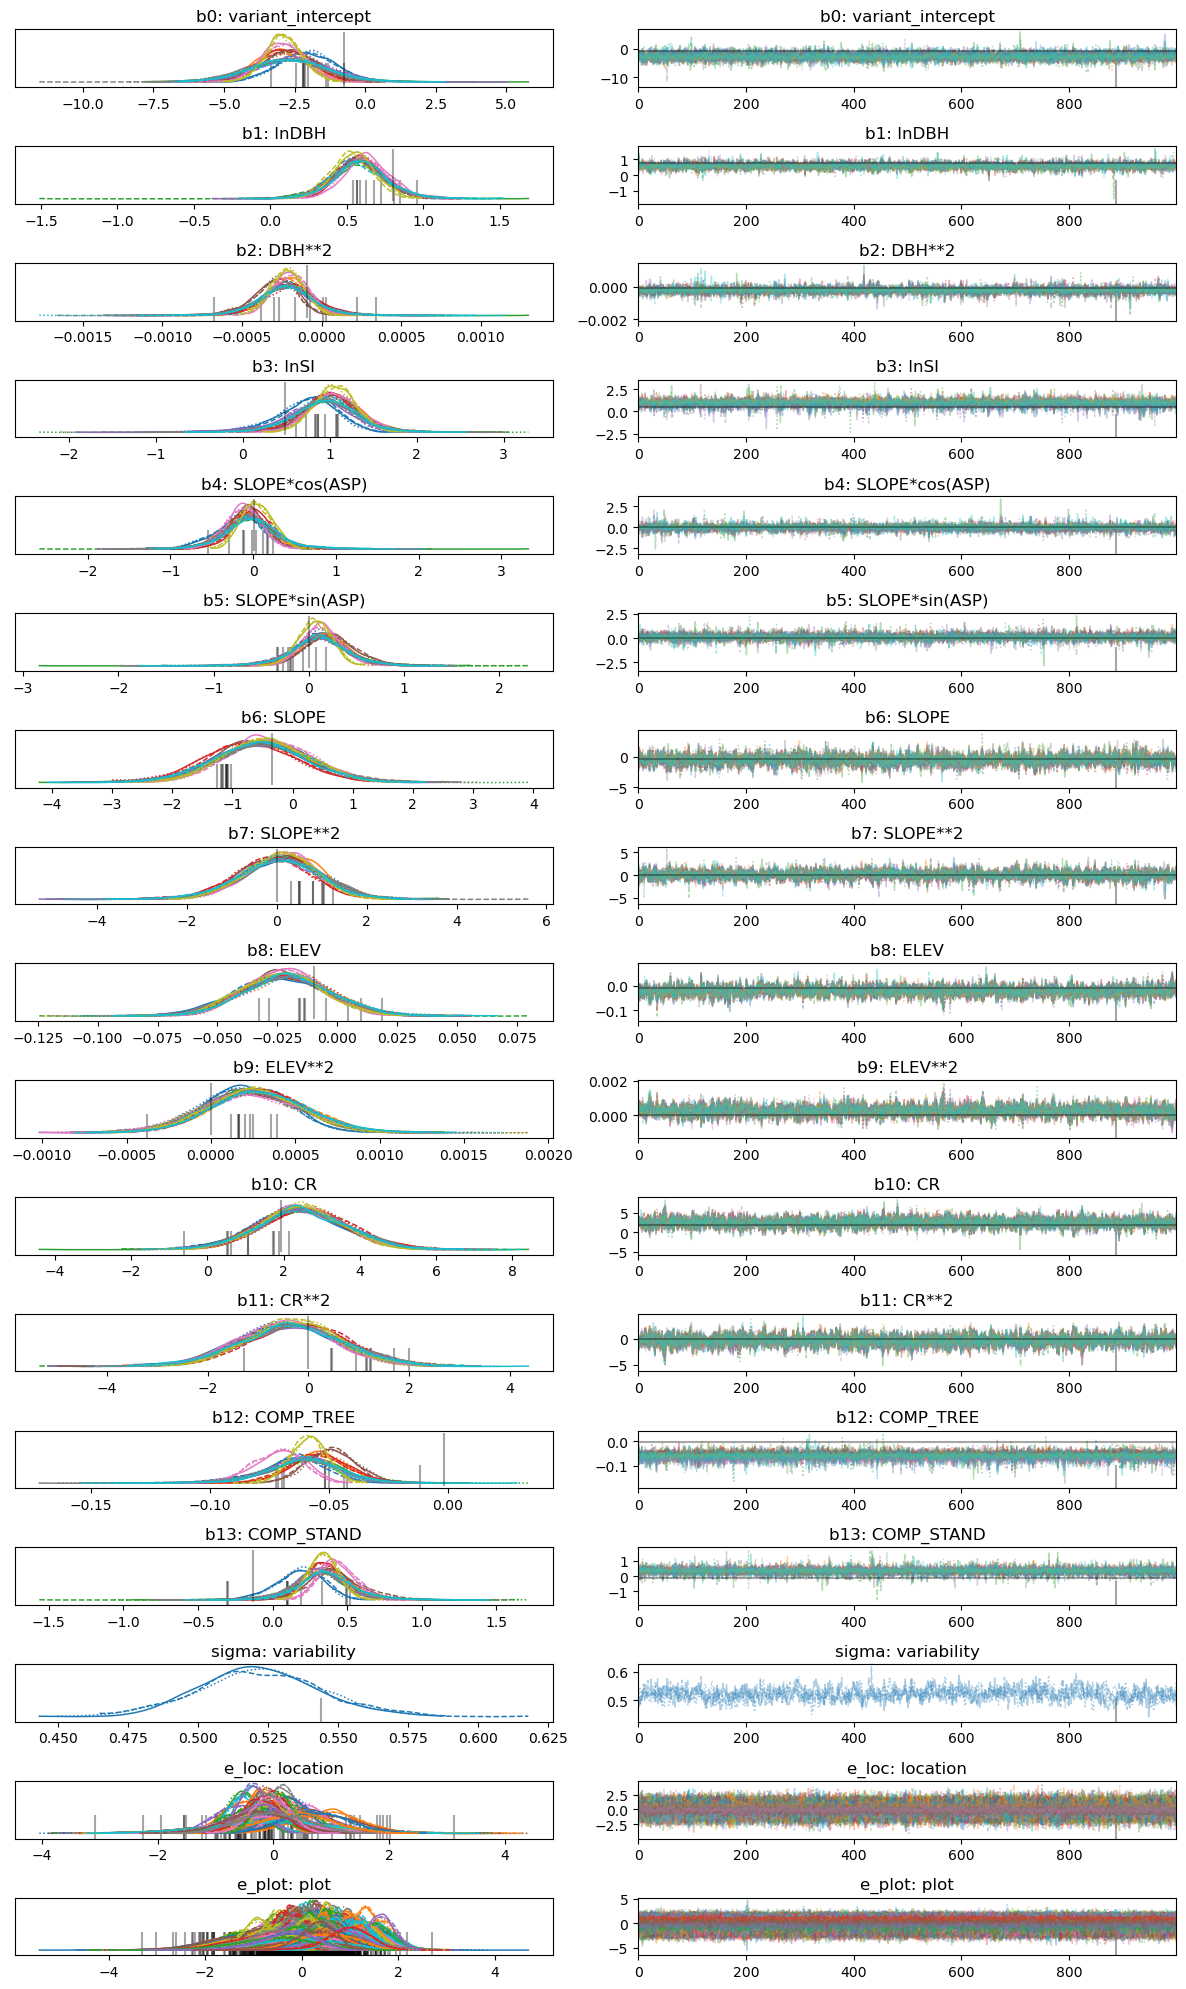

In [25]:
# fig, axs = plt.subplots(15, 2, figsize=(12,20))
fig, axs = plt.subplots(17, 2, figsize=(12,20))
lines = [(var_name, {}, PRIOR_MEAN[var_name]) for var_name in PRIOR_MEAN]
az.plot_trace(result, var_names=DISPLAY_PARAMS, 
              lines=lines, 
              axes=axs)
for i, p in enumerate(DISPLAY_PARAMS):
    for ax in axs[i,:]:
        ax.set_title(f'{p}: {DISPLAY_NAMES[i]}')
plt.tight_layout()
plt.show()

In [26]:
samples = mcmc.get_samples()
posterior = numpyro.infer.Predictive(decentered_model, posterior_samples=samples)
prior = numpyro.infer.Predictive(decentered_model, num_samples=100)
rng_key, rng_key_ = random.split(rng_key)
sorted_data = to_model.sort_values(by=['DG_OBS'])
post_pred = posterior(rng_key, 
          X=tuple(sorted_data[col].values for col in MODEL_COVARS),
          num_steps=10,
          y=None)

prior_pred = prior(rng_key,
                   X=tuple(sorted_data[col].values for col in MODEL_COVARS),
                   num_steps=10,
                   y=None)

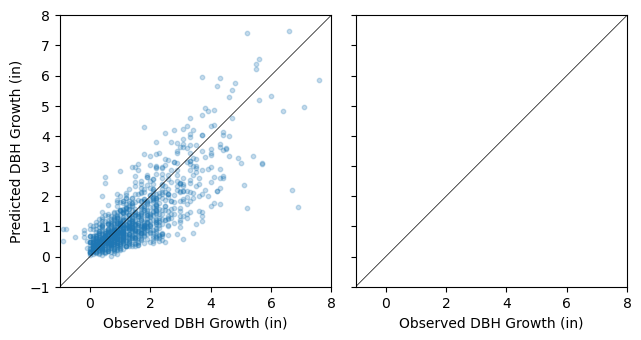

In [27]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
axs[0].scatter(sorted_data['DG_OBS'].values, post_pred['obs'].mean(axis=0), s=10.0, alpha=0.25)
axs[1].scatter(sorted_data['DG_OBS'].values, prior_pred['obs'].mean(axis=0), s=10.0, alpha=0.25)
for ax in axs:
    ax.plot([-1,8], [-1,8], color='black', lw=0.5)
    ax.set(ylim=(-1,8), xlim=(-1,8), aspect='equal')
    ax.set(xlabel='Observed DBH Growth (in)')
axs[0].set(ylabel='Predicted DBH Growth (in)')
plt.tight_layout()
plt.show()

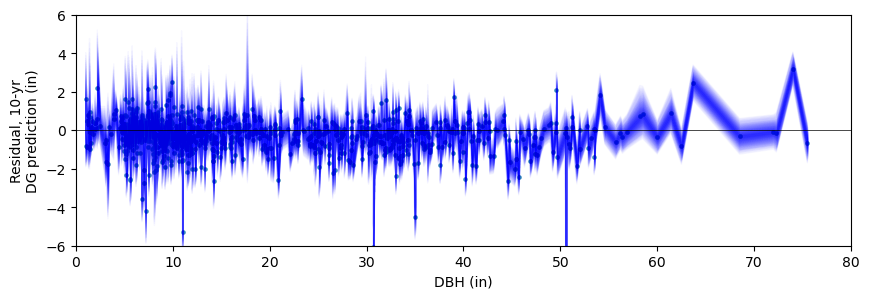

In [28]:
fig, ax = plt.subplots(figsize=(10,3))

d_sort = sorted_data.reset_index(drop=True).sort_values(by=['DBH']).index.values
resid = post_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
ax.scatter(sorted_data['DBH'].values[d_sort], resid.mean(axis=0), s=5.5, alpha=0.8)
qs = np.quantile(resid, q=np.arange(5,96)/100., axis=0)
for q in range(45):
    ax.fill_between(sorted_data['DBH'].values[d_sort], y1=qs[(0+q)], y2=qs[-(1+q)], color='blue', alpha=0.03)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(0,80),
      xlabel='DBH (in)', ylabel='Residual, 10-yr\nDG prediction (in)')
plt.show()

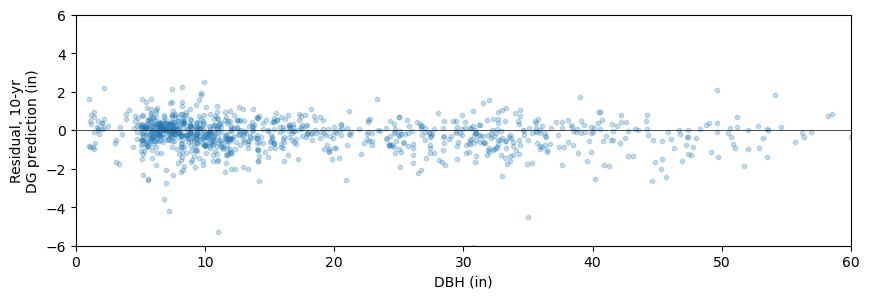

In [29]:
fig, ax = plt.subplots(figsize=(10,3))
d_sort = sorted_data.reset_index(drop=True).sort_values(by=['DBH']).index.values
resid = post_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
ax.scatter(sorted_data['DBH'].values[d_sort], resid.mean(axis=0), s=10.0, alpha=0.25)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(0,60),
       xlabel='DBH (in)', ylabel='Residual, 10-yr\nDG prediction (in)'
      )
plt.show()

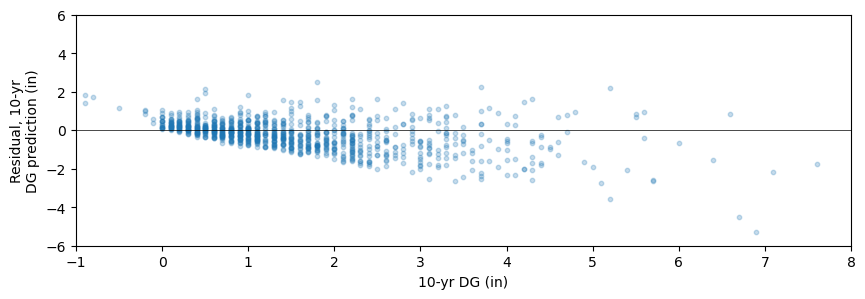

In [30]:
fig, ax = plt.subplots(figsize=(10,3))
resid = post_pred['obs'] - sorted_data['DG_OBS'].values
ax.scatter(sorted_data['DG_OBS'].values, resid.mean(axis=0), s=10.0, alpha=0.25)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(-1,8),
       xlabel='10-yr DG (in)', ylabel='Residual, 10-yr\nDG prediction (in)'
      )
plt.show()